In [1]:
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil

from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(0,1))
pts = PowerTransformer()
scaler = StandardScaler()

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN
from sklearn.decomposition import PCA

In [2]:
gdf = gpd.read_file(f"zip://statistical-gis-boundaries-london.zip!statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LSOA11CD   4835 non-null   object  
 1   LSOA11NM   4835 non-null   object  
 2   MSOA11CD   4835 non-null   object  
 3   MSOA11NM   4835 non-null   object  
 4   LAD11CD    4835 non-null   object  
 5   LAD11NM    4835 non-null   object  
 6   RGN11CD    4835 non-null   object  
 7   RGN11NM    4835 non-null   object  
 8   USUALRES   4835 non-null   int64   
 9   HHOLDRES   4835 non-null   int64   
 10  COMESTRES  4835 non-null   int64   
 11  POPDEN     4835 non-null   float64 
 12  HHOLDS     4835 non-null   int64   
 13  AVHHOLDSZ  4835 non-null   float64 
 14  geometry   4835 non-null   geometry
dtypes: float64(2), geometry(1), int64(4), object(8)
memory usage: 566.7+ KB


In [3]:
df = pd.read_csv('IMDsocre.csv', na_values=[':'], low_memory=False)

In [4]:
df

,LSOAcode,IMDScore,IncomeScore,EmploymentScore,EducationSkillsandTrainingScore,HealthDeprivationandDisabilityScore,CrimeScore,BarrierstoHousingandServicesScore,LivingEnvironmentScore
0,E01000001,6.208,0.007,0.010,0.024,-1.654,-2.012,29.472,31.873
1,E01000002,5.143,0.034,0.027,0.063,-1.115,-2.343,24.412,23.084
2,E01000003,19.402,0.086,0.086,5.804,-0.102,-1.032,40.103,40.535
3,E01000005,28.652,0.211,0.136,22.260,-0.121,-1.317,39.900,28.979
4,E01032739,13.584,0.014,0.011,1.771,-0.676,-1.560,46.314,49.165
...,...,...,...,...,...,...,...,...,...
4830,E01033604,33.467,0.204,0.151,12.981,-0.227,1.363,27.769,45.528
4831,E01033605,40.540,0.313,0.200,19.996,0.388,0.705,25.353,34.149
4832,E01033606,14.013,0.077,0.059,5.118,-0.274,0.136,25.424,34.478
4833,E01033607,22.192,0.125,0.096,1.674,-0.480,1.095,23.500,43.709


In [5]:
print(df.shape)
df.drop(index=df[df.IMDScore.isna()].index, inplace=True)
print(df.shape)

(4835, 9)
(4835, 9)


In [6]:
ppd = pd.merge(gdf, df, left_on='LSOA11CD', right_on='LSOAcode', how='inner').reset_index()
ppd.shape
ppd.sample(3)

,index,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,...,geometry,LSOAcode,IMDScore,IncomeScore,EmploymentScore,EducationSkillsandTrainingScore,HealthDeprivationandDisabilityScore,CrimeScore,BarrierstoHousingandServicesScore,LivingEnvironmentScore
1375,1375,E01001396,Enfield 036D,E02000312,Enfield 036,E09000010,Enfield,E12000007,London,1413,...,"POLYGON ((530993.000 191920.001, 530985.391 19...",E01001396,19.048,0.145,0.059,12.238,-0.823,0.508,33.461,29.032
1856,1856,E01001903,Hammersmith and Fulham 019D,E02000390,Hammersmith and Fulham 019,E09000013,Hammersmith and Fulham,E12000007,London,1649,...,"POLYGON ((524346.911 177504.542, 524356.625 17...",E01001903,25.552,0.181,0.118,7.243,0.227,0.195,26.845,39.844
1741,1741,E01001784,Hackney 027E,E02000371,Hackney 027,E09000012,Hackney,E12000007,London,2273,...,"POLYGON ((533260.345 183212.291, 533261.774 18...",E01001784,26.639,0.182,0.079,14.098,0.139,0.079,42.258,38.620


In [7]:
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

In [8]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

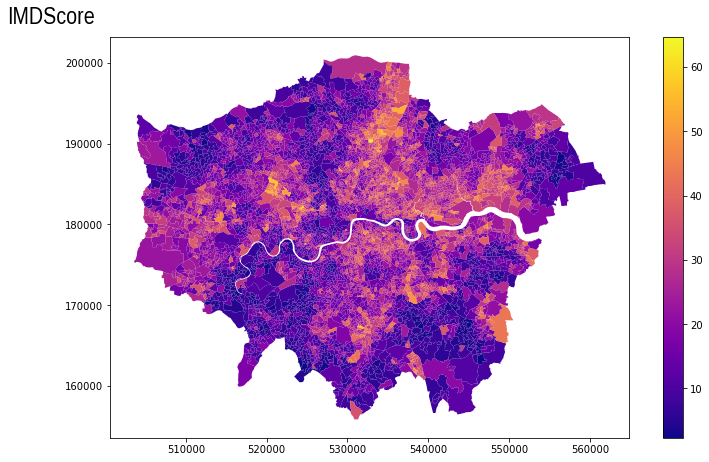

In [9]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
ppd.plot(column='IMDScore', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle(f"IMDScore", x=0.025, size=24, **tfont);
plt.savefig('Cluster_IMD_Score_Raw.png', dpi=150)

In [10]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
rs = RobustScaler(quantile_range=(10.0, 90.0))

In [11]:
ppd = ppd[['LSOA11CD','LSOA11NM','geometry','IncomeScore','EmploymentScore', 'EducationSkillsandTrainingScore','HealthDeprivationandDisabilityScore','CrimeScore','BarrierstoHousingandServicesScore','LivingEnvironmentScore']].copy()
ppd.head()

,LSOA11CD,LSOA11NM,geometry,IncomeScore,EmploymentScore,EducationSkillsandTrainingScore,HealthDeprivationandDisabilityScore,CrimeScore,BarrierstoHousingandServicesScore,LivingEnvironmentScore
0,E01000001,City of London 001A,"POLYGON ((532105.092 182011.230, 532162.491 18...",0.007,0.010,0.024,-1.654,-2.012,29.472,31.873
1,E01000002,City of London 001B,"POLYGON ((532746.813 181786.891, 532671.688 18...",0.034,0.027,0.063,-1.115,-2.343,24.412,23.084
2,E01000003,City of London 001C,"POLYGON ((532135.145 182198.119, 532158.250 18...",0.086,0.086,5.804,-0.102,-1.032,40.103,40.535
3,E01000005,City of London 001E,"POLYGON ((533807.946 180767.770, 533649.063 18...",0.211,0.136,22.260,-0.121,-1.317,39.900,28.979
4,E01000006,Barking and Dagenham 016A,"POLYGON ((545122.049 184314.931, 545271.917 18...",0.117,0.059,14.798,-0.359,-0.147,45.171,26.888


In [12]:
to_cluster = ppd[['LSOA11CD','IncomeScore','EmploymentScore', 'EducationSkillsandTrainingScore','HealthDeprivationandDisabilityScore','CrimeScore','BarrierstoHousingandServicesScore','LivingEnvironmentScore']].set_index('LSOA11CD').copy()
to_cluster.head()

,IncomeScore,EmploymentScore,EducationSkillsandTrainingScore,HealthDeprivationandDisabilityScore,CrimeScore,BarrierstoHousingandServicesScore,LivingEnvironmentScore
LSOA11CD,,,,,,,
E01000001,0.007,0.010,0.024,-1.654,-2.012,29.472,31.873
E01000002,0.034,0.027,0.063,-1.115,-2.343,24.412,23.084
E01000003,0.086,0.086,5.804,-0.102,-1.032,40.103,40.535
E01000005,0.211,0.136,22.260,-0.121,-1.317,39.900,28.979
E01000006,0.117,0.059,14.798,-0.359,-0.147,45.171,26.888


<AxesSubplot:ylabel='Frequency'>

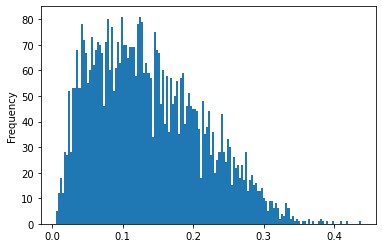

In [13]:
to_cluster.IncomeScore.plot.hist(bins=150)

In [14]:
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(0,1))
pts = PowerTransformer()

In [15]:
normed = to_cluster.copy()
for c in to_cluster.columns.values:
    normed[c] = pts.fit_transform(to_cluster[c].values.reshape(-1,1))
normed.head()

,IncomeScore,EmploymentScore,EducationSkillsandTrainingScore,HealthDeprivationandDisabilityScore,CrimeScore,BarrierstoHousingandServicesScore,LivingEnvironmentScore
LSOA11CD,,,,,,,
E01000001,-2.102521,-2.151705,-2.119923,-1.655320,-3.701346,-0.156112,0.345979
E01000002,-1.542705,-1.529208,-2.098216,-1.040043,-4.204467,-0.707387,-0.490427
E01000003,-0.613480,0.128037,-0.615648,0.319567,-2.173617,0.885454,1.047386
E01000005,1.026243,1.091218,0.981585,0.290379,-2.624668,0.866751,0.087226
E01000006,-0.138139,-0.545713,0.409527,-0.060241,-0.723367,1.340070,-0.109175


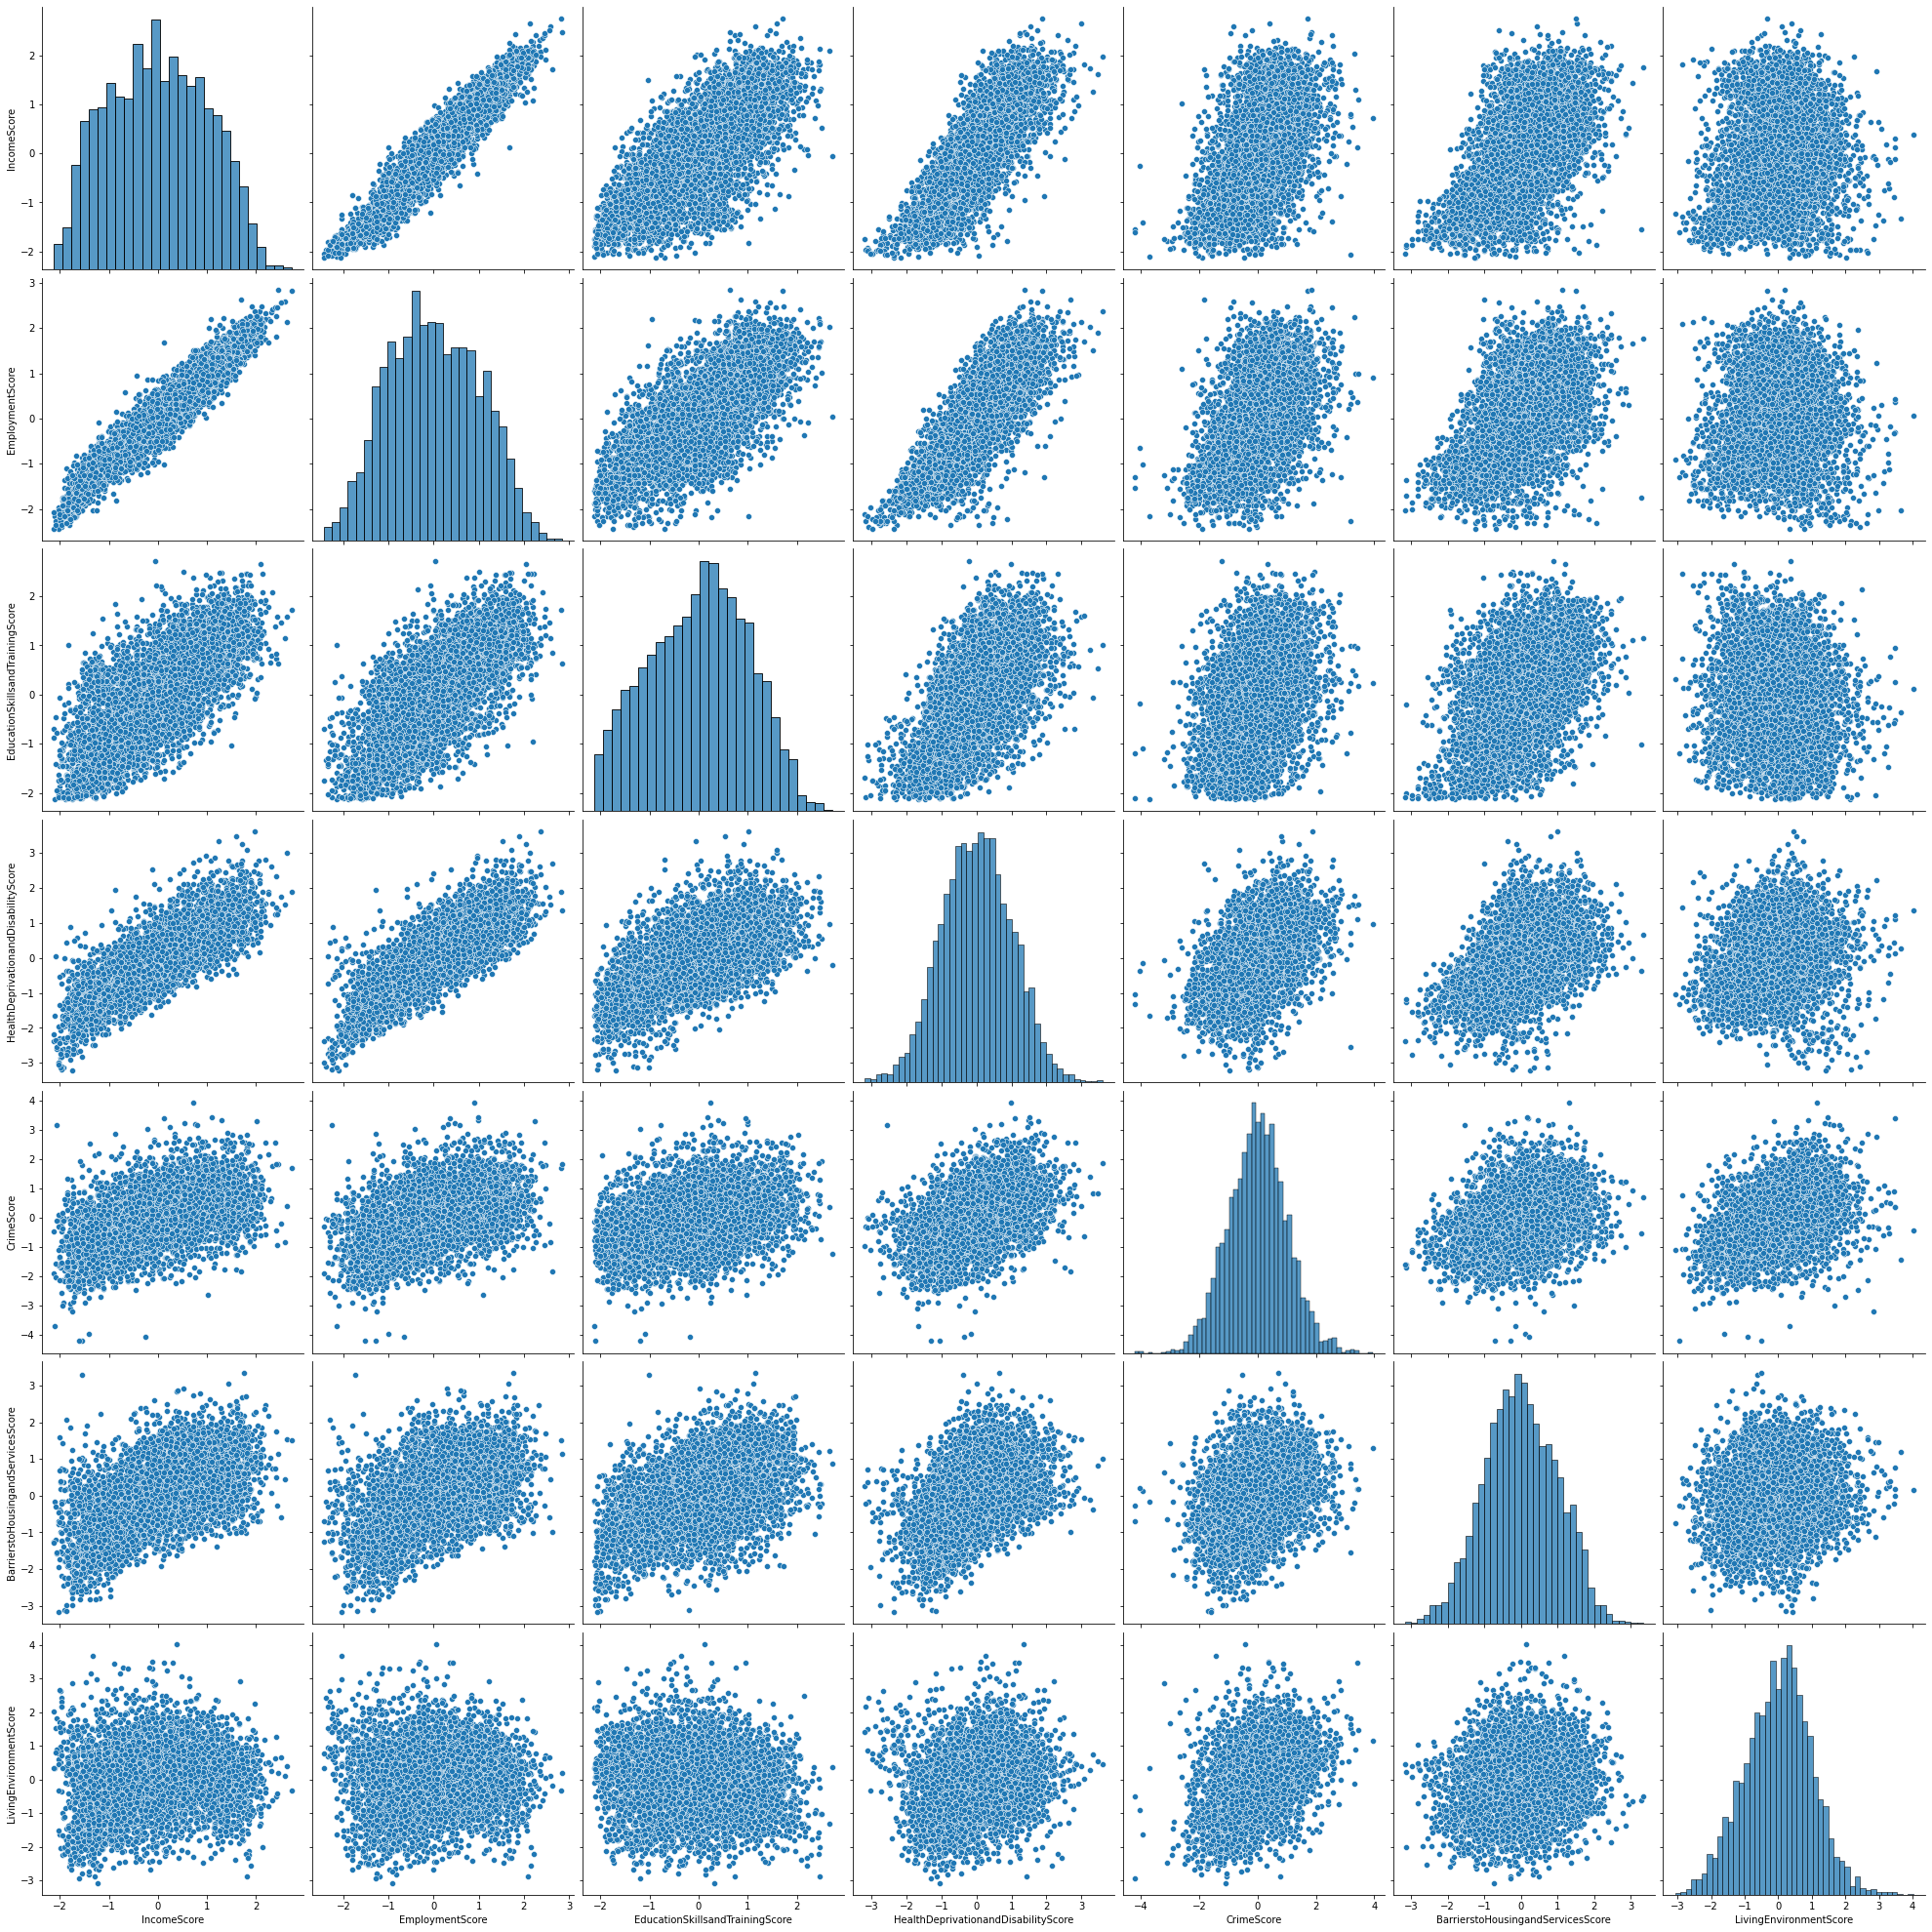

In [16]:
plot_norm = sns.pairplot(normed,height = 4)

In [17]:
rand_st_int = 10 
pca = PCA(random_state=rand_st_int)

normed_pca = pca.fit_transform(normed)
print('Explained variance ratio of each component:')
print(pca.explained_variance_ratio_)

Explained variance ratio of each component:
[0.58261774 0.17267684 0.09065712 0.07012676 0.04787756 0.03047614
 0.00556784]


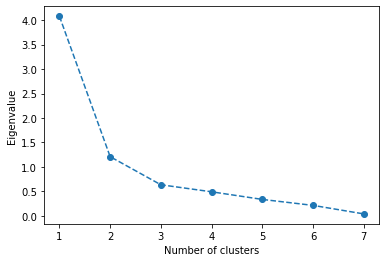

In [18]:
dfpc = pd.DataFrame({'eigenvalue':pca.explained_variance_,
             'PC':list(range(1, pca.n_components_ + 1))})

plt.plot(dfpc['PC'], dfpc['eigenvalue'], marker='o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('Eigenvalue')
plt.show()

In [19]:
pca = PCA(n_components = 2)

normed_pca = pca.fit_transform(normed)
print('Explained variance ratio of each component:')
print(pca.explained_variance_ratio_)

Explained variance ratio of each component:
[0.58261774 0.17267684]


In [20]:
list_var = normed.columns.tolist()
print(list_var)

['IncomeScore', 'EmploymentScore', 'EducationSkillsandTrainingScore', 'HealthDeprivationandDisabilityScore', 'CrimeScore', 'BarrierstoHousingandServicesScore', 'LivingEnvironmentScore']


In [21]:
df_PrincipleComp = pd.DataFrame(pca.components_, columns = list_var)
df_PrincipleComp

,IncomeScore,EmploymentScore,EducationSkillsandTrainingScore,HealthDeprivationandDisabilityScore,CrimeScore,BarrierstoHousingandServicesScore,LivingEnvironmentScore
0,-0.473028,-0.461918,-0.392992,-0.430387,-0.316776,-0.333329,-0.108379
1,-0.075733,-0.124389,-0.325626,0.022856,0.442496,-0.053131,0.820738


In [22]:
score_pca = pca.transform(normed)
score_pca

array([[ 4.72103875, -0.26623303],
       [ 4.32913007, -1.25887689],
       [ 0.61534446,  0.08907646],
       ...,
       [-1.96902928, -1.55833558],
       [-0.34675054, -1.72285668],
       [-0.03833482,  1.67121896]])

In [23]:
print('Eigenvalues of each component:')
print(pca.explained_variance_)

Eigenvalues of each component:
[4.07916787 1.20898794]


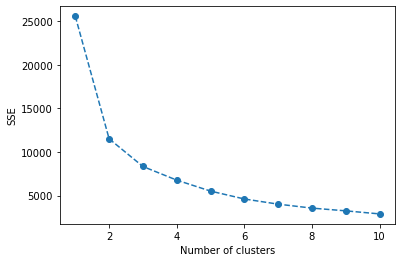

In [24]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='k-means++', random_state=0)
    km.fit(score_pca)
    # inertia is a concept in physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [25]:
k_cluster = 2
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(score_pca)

KMeans(n_clusters=2, random_state=1)

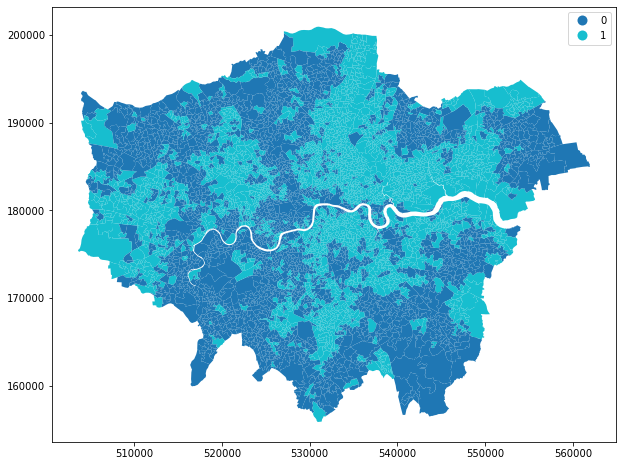

In [26]:
ppd['Kmeans_Cluster'] = kmeans_method.labels_
ppd.plot(column='Kmeans_Cluster', categorical=True, legend=True, figsize=(12,8));

In [27]:
ppd_kpca = pd.concat([ppd.reset_index(drop = True), pd.DataFrame(score_pca)],axis = 1)
ppd_kpca.columns.values[-2: ] = ['Component1','Component2']

In [28]:
ppd_kpca['Segement'] = ppd_kpca['Kmeans_Cluster'].map({0:'First',1:'Second',2:'Third'})

In [29]:
ppd_kpca.head()

,LSOA11CD,LSOA11NM,geometry,IncomeScore,EmploymentScore,EducationSkillsandTrainingScore,HealthDeprivationandDisabilityScore,CrimeScore,BarrierstoHousingandServicesScore,LivingEnvironmentScore,Kmeans_Cluster,Component1,Component2,Segement
0,E01000001,City of London 001A,"POLYGON ((532105.092 182011.230, 532162.491 18...",0.007,0.010,0.024,-1.654,-2.012,29.472,31.873,0,4.721039,-0.266233,First
1,E01000002,City of London 001B,"POLYGON ((532746.813 181786.891, 532671.688 18...",0.034,0.027,0.063,-1.115,-2.343,24.412,23.084,0,4.329130,-1.258877,First
2,E01000003,City of London 001C,"POLYGON ((532135.145 182198.119, 532158.250 18...",0.086,0.086,5.804,-0.102,-1.032,40.103,40.535,0,0.615344,0.089076,First
3,E01000005,City of London 001E,"POLYGON ((533807.946 180767.770, 533649.063 18...",0.211,0.136,22.260,-0.121,-1.317,39.900,28.979,1,-0.967161,-1.662316,Second
4,E01000006,Barking and Dagenham 016A,"POLYGON ((545122.049 184314.931, 545271.917 18...",0.117,0.059,14.798,-0.359,-0.147,45.171,26.888,1,-0.023302,-0.537277,Second


/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


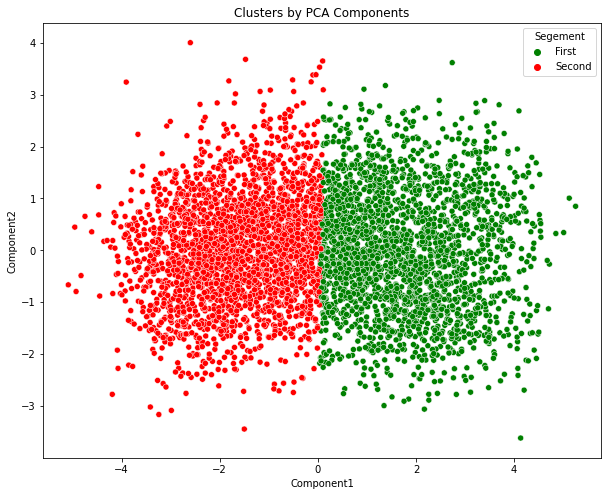

In [31]:
x_axis = ppd_kpca['Component1']
y_axis = ppd_kpca['Component2']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis,y_axis,hue = ppd_kpca['Segement'], palette = ['g','r'])
plt.title('Clusters by PCA Components')
plt.show()